In [1]:
import wooldridge as woo
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import statsmodels.formula.api as smf
import scipy.stats as stats
import seaborn as sns


In [2]:
ceo = woo.data('ceosal1')

In [3]:
ceo.head()

,salary,pcsalary,sales,roe,pcroe,ros,indus,finance,consprod,utility,lsalary,lsales
0,1095,20,27595.000000,14.1,106.400002,191,1,0,0,0,6.998509,10.225389
1,1001,32,9958.000000,10.9,-30.600000,13,1,0,0,0,6.908755,9.206132
2,1122,9,6125.899902,23.5,-16.299999,14,1,0,0,0,7.022868,8.720281
3,578,-9,16246.000000,5.9,-25.700001,-21,1,0,0,0,6.359574,9.695602
4,1368,7,21783.199219,13.8,-3.000000,56,1,0,0,0,7.221105,9.988894


### Error Normality

Jarque-Bera Test:

$$JB = \frac{N}{6}(S^2+\frac{(k-3)^2}{4})$$

where k is kurtosis and s is skewness. $H_0: JB = 0$. If we reject the null hypothesis, would conclude that they residuals are likely not normal.

In [4]:
reg = smf.ols('np.log(salary) ~ np.log(sales)', data = ceo)
results = reg.fit()

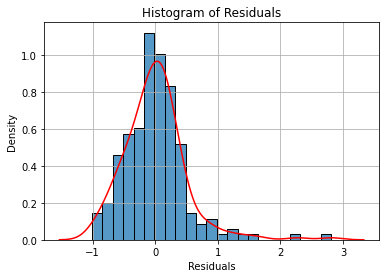

In [5]:
sns.kdeplot(results.resid, color = "red")
sns.histplot(results.resid, stat = "density")
plt.title("Histogram of Residuals")
plt.xlabel("Residuals")
plt.grid()

In [6]:
def jarque_bera(results):
    uhat = results.resid
    
    # Pull variables
    S = stats.skew(uhat)
    k = stats.kurtosis(uhat, fisher = False)
    N = len(uhat)
    
    # calculate
    JB = (N/6)*(S**2+((k-3)**2)/4)
    
    return JB

In [7]:
jarque_bera(results)

403.8308938784626

In [8]:
import scipy.stats as stats
stats.jarque_bera(results.resid)

Jarque_beraResult(statistic=403.8308938784626, pvalue=0.0)

In [9]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         np.log(salary)   R-squared:                       0.211
Model:                            OLS   Adj. R-squared:                  0.207
Method:                 Least Squares   F-statistic:                     55.30
Date:                Thu, 27 Oct 2022   Prob (F-statistic):           2.70e-12
Time:                        10:09:12   Log-Likelihood:                -152.50
No. Observations:                 209   AIC:                             309.0
Df Residuals:                     207   BIC:                             315.7
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept         4.8220      0.288     16.723      0.000       4.254       5.390
np.log(sales)     0.2567      0.035      7.436      0.000       0.189       0.325
==============================================================================
Omnibus:                       84.151   Durbin-Watson:                   1.860
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              403.831
Skew:                           1.507   Prob(JB):                     2.04e-88
Kurtosis:                       9.106   Cond. No.                         70.0
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

We reject the null hypothesis that the residuals are normally distributed. Hypothesis tests and confidence intervals rely on the assumption that errors are normal (in samples that are not large). Thus these may not be reliable, especially in smaller samples, if ther residuals are not normal. 

### Prediction and Confidence Intervals

In [10]:
# get xrange
xrange = np.linspace(ceo.sales.min(), ceo.sales.max(), 200)

# Put in format that works with get_predictions()
new_data = pd.DataFrame(xrange, columns = ["sales"])

In [11]:
# Generate predictions over range
predictions = results.get_prediction(new_data)

# Generate table with intervals for each x
predictions = predictions.summary_frame(alpha=0.05)

In [12]:
predictions

,mean,mean_se,mean_ci_lower,mean_ci_upper,obs_ci_lower,obs_ci_upper
0,6.147944,0.113410,5.924357,6.371531,5.128780,7.167108
1,6.490317,0.071028,6.350286,6.630347,5.486168,7.494465
2,6.631974,0.055232,6.523084,6.740864,5.631693,7.632255
3,6.722726,0.046416,6.631218,6.814234,5.724187,7.721264
4,6.789637,0.041042,6.708724,6.870551,5.792014,7.787261
...,...,...,...,...,...,...
195,7.765732,0.115062,7.538888,7.992577,6.745848,8.785616
196,7.767043,0.115230,7.539867,7.994218,6.747085,8.787000
197,7.768346,0.115397,7.540841,7.995852,6.748315,8.788378
198,7.769644,0.115564,7.541811,7.997477,6.749539,8.789748


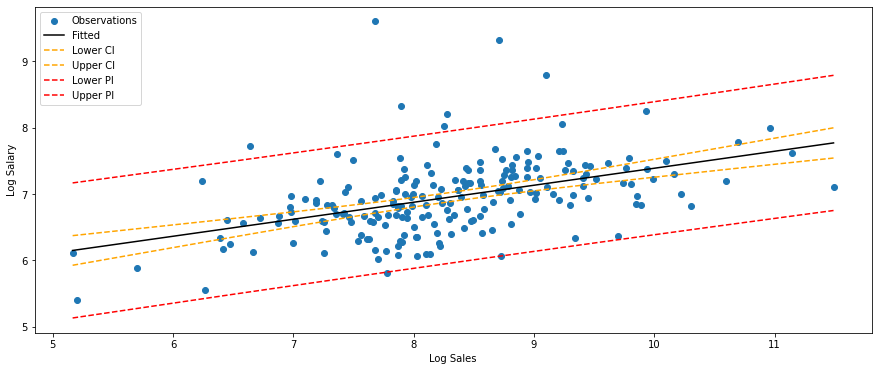

In [13]:
plt.figure(figsize = (15, 6))
plt.scatter(np.log(ceo.sales), np.log(ceo.salary))
plt.plot(np.log(xrange), predictions["mean"], color = "black")

plt.xlabel("Log Sales")
plt.ylabel("Log Salary")

# confidence Intervals
plt.plot(np.log(xrange), predictions["mean_ci_lower"], color = "orange", linestyle = '--')
plt.plot(np.log(xrange), predictions["mean_ci_upper"], color = "orange", linestyle = '--')

# prediction Intervals
plt.plot(np.log(xrange), predictions["obs_ci_lower"], color = "red", linestyle = '--')
plt.plot(np.log(xrange), predictions["obs_ci_upper"], color = "red", linestyle = '--')

plt.legend(["Observations", "Fitted", "Lower CI", "Upper CI","Lower PI", "Upper PI"])

### K-fold Cross Validation

In [14]:
ceo[:25]

,salary,pcsalary,sales,roe,pcroe,ros,indus,finance,consprod,utility,lsalary,lsales
0,1095,20,27595.000000,14.100000,106.400002,191,1,0,0,0,6.998509,10.225389
1,1001,32,9958.000000,10.900000,-30.600000,13,1,0,0,0,6.908755,9.206132
2,1122,9,6125.899902,23.500000,-16.299999,14,1,0,0,0,7.022868,8.720281
3,578,-9,16246.000000,5.900000,-25.700001,-21,1,0,0,0,6.359574,9.695602
4,1368,7,21783.199219,13.800000,-3.000000,56,1,0,0,0,7.221105,9.988894
5,1145,5,6021.399902,20.000000,1.000000,55,1,0,0,0,7.043160,8.703075
6,1078,10,2266.699951,16.400000,-5.900000,62,1,0,0,0,6.982863,7.726080
7,1094,7,2966.800049,16.299999,-1.600000,44,1,0,0,0,6.997596,7.995239
8,1237,16,4570.200195,10.500000,-70.199997,37,1,0,0,0,7.120444,8.427312
9,833,5,2830.000000,26.299999,-23.900000,37,1,0,0,0,6.725034,7.948032


In [15]:
from sklearn.model_selection import KFold # import KFold

In [16]:
kf = KFold(n_splits = 3)
for train_index, test_index in kf.split(ceo):
    print("TRAIN:", train_index, "TEST:", test_index)

TRAIN: [ 70  71  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87
  88  89  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105
 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123
 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141
 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159
 160 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177
 178 179 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195
 196 197 198 199 200 201 202 203 204 205 206 207 208] TEST: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69]
TRAIN: [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  4

In [17]:
# split the data into 5 subsets
kf = KFold(n_splits = 5)

mse = []
for train_index, test_index in kf.split(ceo):
    # train data over training set
    results = smf.ols('np.log(salary) ~ np.log(sales)', ceo.iloc[train_index]).fit()
    
    # test over last split 
    s = ((np.log(ceo.iloc[test_index]["salary"]) - results.predict(ceo.iloc[test_index]))**2).mean()
    
    # append test metric
    mse.append(s)

In [18]:
mse

[0.12340491612500959,
 0.13110902468036217,
 0.25738009241286347,
 0.34446212923334874,
 0.48735352503510077]

In [19]:
reg = smf.ols('np.log(salary) ~ np.log(sales)', data = ceo)
results = reg.fit()
(results.resid**2).mean()

0.25194256243566804

In [20]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score

x = np.log(ceo[['sales']])
y = np.log(ceo[['salary']])

regr = LinearRegression()
scores = cross_val_score(regr, x, y, cv=5, scoring='neg_mean_squared_error')
print('5-Fold CV MSE Scores:', scores)

5-Fold CV MSE Scores: [-0.12340492 -0.13110902 -0.25738009 -0.34446213 -0.48735353]


### Bootstrapping Regression Models

In [21]:
# build dataframe to store sample statistics
coefs = pd.DataFrame(columns = ["B0","B1"])

# we will generate 1000 bootstrap samples
for i in range(1000):
    
    # sample from the data with replacement N times
    sample = ceo.sample(ceo.shape[0] ,replace = True)
    
    # fit model on bootstrap sample
    results = smf.ols('np.log(salary) ~ np.log(sales)', sample).fit()
    
    # pull out the bootstrap sample statistics
    b0,b1 = results.params
    
    # store the bootstrap sample statistics for later use
    coefs = coefs.append({"B0":b0, "B1":b1}, ignore_index = True)

# below I calculate the percentile bootstraps for a 95% confidence interval

# the 97.5 percentile of thebootstrap sample statistics
b0_u, b1_u = coefs.quantile(.975)

# the 2.5 percentile of the bootstrap sample statistics
b0_l, b1_l = coefs.quantile(.025)

/var/folders/81/jjv33vws4cs7b2lsyrkgf1q00000gn/T/ipykernel_2949/1994714894.py:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  coefs = coefs.append({"B0":b0, "B1":b1}, ignore_index = True)
/var/folders/81/jjv33vws4cs7b2lsyrkgf1q00000gn/T/ipykernel_2949/1994714894.py:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  coefs = coefs.append({"B0":b0, "B1":b1}, ignore_index = True)
/var/folders/81/jjv33vws4cs7b2lsyrkgf1q00000gn/T/ipykernel_2949/1994714894.py:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  coefs = coefs.append({"B0":b0, "B1":b1}, ignore_index = True)
/var/folders/81/jjv33vws4cs7b2lsyrkgf1q00000gn/T/ipykernel_2949/1994714894.py:17: FutureWarning: The frame.append method is deprecated and will be removed from pan

/var/folders/81/jjv33vws4cs7b2lsyrkgf1q00000gn/T/ipykernel_2949/1994714894.py:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  coefs = coefs.append({"B0":b0, "B1":b1}, ignore_index = True)
/var/folders/81/jjv33vws4cs7b2lsyrkgf1q00000gn/T/ipykernel_2949/1994714894.py:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  coefs = coefs.append({"B0":b0, "B1":b1}, ignore_index = True)
/var/folders/81/jjv33vws4cs7b2lsyrkgf1q00000gn/T/ipykernel_2949/1994714894.py:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  coefs = coefs.append({"B0":b0, "B1":b1}, ignore_index = True)
/var/folders/81/jjv33vws4cs7b2lsyrkgf1q00000gn/T/ipykernel_2949/1994714894.py:17: FutureWarning: The frame.append method is deprecated and will be removed from pan

/var/folders/81/jjv33vws4cs7b2lsyrkgf1q00000gn/T/ipykernel_2949/1994714894.py:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  coefs = coefs.append({"B0":b0, "B1":b1}, ignore_index = True)
/var/folders/81/jjv33vws4cs7b2lsyrkgf1q00000gn/T/ipykernel_2949/1994714894.py:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  coefs = coefs.append({"B0":b0, "B1":b1}, ignore_index = True)
/var/folders/81/jjv33vws4cs7b2lsyrkgf1q00000gn/T/ipykernel_2949/1994714894.py:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  coefs = coefs.append({"B0":b0, "B1":b1}, ignore_index = True)
/var/folders/81/jjv33vws4cs7b2lsyrkgf1q00000gn/T/ipykernel_2949/1994714894.py:17: FutureWarning: The frame.append method is deprecated and will be removed from pan

/var/folders/81/jjv33vws4cs7b2lsyrkgf1q00000gn/T/ipykernel_2949/1994714894.py:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  coefs = coefs.append({"B0":b0, "B1":b1}, ignore_index = True)
/var/folders/81/jjv33vws4cs7b2lsyrkgf1q00000gn/T/ipykernel_2949/1994714894.py:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  coefs = coefs.append({"B0":b0, "B1":b1}, ignore_index = True)
/var/folders/81/jjv33vws4cs7b2lsyrkgf1q00000gn/T/ipykernel_2949/1994714894.py:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  coefs = coefs.append({"B0":b0, "B1":b1}, ignore_index = True)
/var/folders/81/jjv33vws4cs7b2lsyrkgf1q00000gn/T/ipykernel_2949/1994714894.py:17: FutureWarning: The frame.append method is deprecated and will be removed from pan

/var/folders/81/jjv33vws4cs7b2lsyrkgf1q00000gn/T/ipykernel_2949/1994714894.py:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  coefs = coefs.append({"B0":b0, "B1":b1}, ignore_index = True)
/var/folders/81/jjv33vws4cs7b2lsyrkgf1q00000gn/T/ipykernel_2949/1994714894.py:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  coefs = coefs.append({"B0":b0, "B1":b1}, ignore_index = True)
/var/folders/81/jjv33vws4cs7b2lsyrkgf1q00000gn/T/ipykernel_2949/1994714894.py:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  coefs = coefs.append({"B0":b0, "B1":b1}, ignore_index = True)
/var/folders/81/jjv33vws4cs7b2lsyrkgf1q00000gn/T/ipykernel_2949/1994714894.py:17: FutureWarning: The frame.append method is deprecated and will be removed from pan

/var/folders/81/jjv33vws4cs7b2lsyrkgf1q00000gn/T/ipykernel_2949/1994714894.py:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  coefs = coefs.append({"B0":b0, "B1":b1}, ignore_index = True)
/var/folders/81/jjv33vws4cs7b2lsyrkgf1q00000gn/T/ipykernel_2949/1994714894.py:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  coefs = coefs.append({"B0":b0, "B1":b1}, ignore_index = True)
/var/folders/81/jjv33vws4cs7b2lsyrkgf1q00000gn/T/ipykernel_2949/1994714894.py:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  coefs = coefs.append({"B0":b0, "B1":b1}, ignore_index = True)
/var/folders/81/jjv33vws4cs7b2lsyrkgf1q00000gn/T/ipykernel_2949/1994714894.py:17: FutureWarning: The frame.append method is deprecated and will be removed from pan

/var/folders/81/jjv33vws4cs7b2lsyrkgf1q00000gn/T/ipykernel_2949/1994714894.py:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  coefs = coefs.append({"B0":b0, "B1":b1}, ignore_index = True)
/var/folders/81/jjv33vws4cs7b2lsyrkgf1q00000gn/T/ipykernel_2949/1994714894.py:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  coefs = coefs.append({"B0":b0, "B1":b1}, ignore_index = True)
/var/folders/81/jjv33vws4cs7b2lsyrkgf1q00000gn/T/ipykernel_2949/1994714894.py:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  coefs = coefs.append({"B0":b0, "B1":b1}, ignore_index = True)
/var/folders/81/jjv33vws4cs7b2lsyrkgf1q00000gn/T/ipykernel_2949/1994714894.py:17: FutureWarning: The frame.append method is deprecated and will be removed from pan

/var/folders/81/jjv33vws4cs7b2lsyrkgf1q00000gn/T/ipykernel_2949/1994714894.py:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  coefs = coefs.append({"B0":b0, "B1":b1}, ignore_index = True)
/var/folders/81/jjv33vws4cs7b2lsyrkgf1q00000gn/T/ipykernel_2949/1994714894.py:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  coefs = coefs.append({"B0":b0, "B1":b1}, ignore_index = True)
/var/folders/81/jjv33vws4cs7b2lsyrkgf1q00000gn/T/ipykernel_2949/1994714894.py:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  coefs = coefs.append({"B0":b0, "B1":b1}, ignore_index = True)
/var/folders/81/jjv33vws4cs7b2lsyrkgf1q00000gn/T/ipykernel_2949/1994714894.py:17: FutureWarning: The frame.append method is deprecated and will be removed from pan

/var/folders/81/jjv33vws4cs7b2lsyrkgf1q00000gn/T/ipykernel_2949/1994714894.py:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  coefs = coefs.append({"B0":b0, "B1":b1}, ignore_index = True)
/var/folders/81/jjv33vws4cs7b2lsyrkgf1q00000gn/T/ipykernel_2949/1994714894.py:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  coefs = coefs.append({"B0":b0, "B1":b1}, ignore_index = True)
/var/folders/81/jjv33vws4cs7b2lsyrkgf1q00000gn/T/ipykernel_2949/1994714894.py:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  coefs = coefs.append({"B0":b0, "B1":b1}, ignore_index = True)
/var/folders/81/jjv33vws4cs7b2lsyrkgf1q00000gn/T/ipykernel_2949/1994714894.py:17: FutureWarning: The frame.append method is deprecated and will be removed from pan

/var/folders/81/jjv33vws4cs7b2lsyrkgf1q00000gn/T/ipykernel_2949/1994714894.py:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  coefs = coefs.append({"B0":b0, "B1":b1}, ignore_index = True)
/var/folders/81/jjv33vws4cs7b2lsyrkgf1q00000gn/T/ipykernel_2949/1994714894.py:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  coefs = coefs.append({"B0":b0, "B1":b1}, ignore_index = True)
/var/folders/81/jjv33vws4cs7b2lsyrkgf1q00000gn/T/ipykernel_2949/1994714894.py:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  coefs = coefs.append({"B0":b0, "B1":b1}, ignore_index = True)
/var/folders/81/jjv33vws4cs7b2lsyrkgf1q00000gn/T/ipykernel_2949/1994714894.py:17: FutureWarning: The frame.append method is deprecated and will be removed from pan

/var/folders/81/jjv33vws4cs7b2lsyrkgf1q00000gn/T/ipykernel_2949/1994714894.py:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  coefs = coefs.append({"B0":b0, "B1":b1}, ignore_index = True)
/var/folders/81/jjv33vws4cs7b2lsyrkgf1q00000gn/T/ipykernel_2949/1994714894.py:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  coefs = coefs.append({"B0":b0, "B1":b1}, ignore_index = True)
/var/folders/81/jjv33vws4cs7b2lsyrkgf1q00000gn/T/ipykernel_2949/1994714894.py:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  coefs = coefs.append({"B0":b0, "B1":b1}, ignore_index = True)
/var/folders/81/jjv33vws4cs7b2lsyrkgf1q00000gn/T/ipykernel_2949/1994714894.py:17: FutureWarning: The frame.append method is deprecated and will be removed from pan

/var/folders/81/jjv33vws4cs7b2lsyrkgf1q00000gn/T/ipykernel_2949/1994714894.py:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  coefs = coefs.append({"B0":b0, "B1":b1}, ignore_index = True)
/var/folders/81/jjv33vws4cs7b2lsyrkgf1q00000gn/T/ipykernel_2949/1994714894.py:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  coefs = coefs.append({"B0":b0, "B1":b1}, ignore_index = True)
/var/folders/81/jjv33vws4cs7b2lsyrkgf1q00000gn/T/ipykernel_2949/1994714894.py:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  coefs = coefs.append({"B0":b0, "B1":b1}, ignore_index = True)
/var/folders/81/jjv33vws4cs7b2lsyrkgf1q00000gn/T/ipykernel_2949/1994714894.py:17: FutureWarning: The frame.append method is deprecated and will be removed from pan

/var/folders/81/jjv33vws4cs7b2lsyrkgf1q00000gn/T/ipykernel_2949/1994714894.py:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  coefs = coefs.append({"B0":b0, "B1":b1}, ignore_index = True)
/var/folders/81/jjv33vws4cs7b2lsyrkgf1q00000gn/T/ipykernel_2949/1994714894.py:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  coefs = coefs.append({"B0":b0, "B1":b1}, ignore_index = True)
/var/folders/81/jjv33vws4cs7b2lsyrkgf1q00000gn/T/ipykernel_2949/1994714894.py:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  coefs = coefs.append({"B0":b0, "B1":b1}, ignore_index = True)
/var/folders/81/jjv33vws4cs7b2lsyrkgf1q00000gn/T/ipykernel_2949/1994714894.py:17: FutureWarning: The frame.append method is deprecated and will be removed from pan

/var/folders/81/jjv33vws4cs7b2lsyrkgf1q00000gn/T/ipykernel_2949/1994714894.py:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  coefs = coefs.append({"B0":b0, "B1":b1}, ignore_index = True)
/var/folders/81/jjv33vws4cs7b2lsyrkgf1q00000gn/T/ipykernel_2949/1994714894.py:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  coefs = coefs.append({"B0":b0, "B1":b1}, ignore_index = True)
/var/folders/81/jjv33vws4cs7b2lsyrkgf1q00000gn/T/ipykernel_2949/1994714894.py:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  coefs = coefs.append({"B0":b0, "B1":b1}, ignore_index = True)
/var/folders/81/jjv33vws4cs7b2lsyrkgf1q00000gn/T/ipykernel_2949/1994714894.py:17: FutureWarning: The frame.append method is deprecated and will be removed from pan

/var/folders/81/jjv33vws4cs7b2lsyrkgf1q00000gn/T/ipykernel_2949/1994714894.py:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  coefs = coefs.append({"B0":b0, "B1":b1}, ignore_index = True)
/var/folders/81/jjv33vws4cs7b2lsyrkgf1q00000gn/T/ipykernel_2949/1994714894.py:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  coefs = coefs.append({"B0":b0, "B1":b1}, ignore_index = True)
/var/folders/81/jjv33vws4cs7b2lsyrkgf1q00000gn/T/ipykernel_2949/1994714894.py:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  coefs = coefs.append({"B0":b0, "B1":b1}, ignore_index = True)
/var/folders/81/jjv33vws4cs7b2lsyrkgf1q00000gn/T/ipykernel_2949/1994714894.py:17: FutureWarning: The frame.append method is deprecated and will be removed from pan

/var/folders/81/jjv33vws4cs7b2lsyrkgf1q00000gn/T/ipykernel_2949/1994714894.py:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  coefs = coefs.append({"B0":b0, "B1":b1}, ignore_index = True)
/var/folders/81/jjv33vws4cs7b2lsyrkgf1q00000gn/T/ipykernel_2949/1994714894.py:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  coefs = coefs.append({"B0":b0, "B1":b1}, ignore_index = True)
/var/folders/81/jjv33vws4cs7b2lsyrkgf1q00000gn/T/ipykernel_2949/1994714894.py:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  coefs = coefs.append({"B0":b0, "B1":b1}, ignore_index = True)
/var/folders/81/jjv33vws4cs7b2lsyrkgf1q00000gn/T/ipykernel_2949/1994714894.py:17: FutureWarning: The frame.append method is deprecated and will be removed from pan

/var/folders/81/jjv33vws4cs7b2lsyrkgf1q00000gn/T/ipykernel_2949/1994714894.py:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  coefs = coefs.append({"B0":b0, "B1":b1}, ignore_index = True)
/var/folders/81/jjv33vws4cs7b2lsyrkgf1q00000gn/T/ipykernel_2949/1994714894.py:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  coefs = coefs.append({"B0":b0, "B1":b1}, ignore_index = True)
/var/folders/81/jjv33vws4cs7b2lsyrkgf1q00000gn/T/ipykernel_2949/1994714894.py:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  coefs = coefs.append({"B0":b0, "B1":b1}, ignore_index = True)
/var/folders/81/jjv33vws4cs7b2lsyrkgf1q00000gn/T/ipykernel_2949/1994714894.py:17: FutureWarning: The frame.append method is deprecated and will be removed from pan

/var/folders/81/jjv33vws4cs7b2lsyrkgf1q00000gn/T/ipykernel_2949/1994714894.py:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  coefs = coefs.append({"B0":b0, "B1":b1}, ignore_index = True)
/var/folders/81/jjv33vws4cs7b2lsyrkgf1q00000gn/T/ipykernel_2949/1994714894.py:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  coefs = coefs.append({"B0":b0, "B1":b1}, ignore_index = True)
/var/folders/81/jjv33vws4cs7b2lsyrkgf1q00000gn/T/ipykernel_2949/1994714894.py:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  coefs = coefs.append({"B0":b0, "B1":b1}, ignore_index = True)
/var/folders/81/jjv33vws4cs7b2lsyrkgf1q00000gn/T/ipykernel_2949/1994714894.py:17: FutureWarning: The frame.append method is deprecated and will be removed from pan

/var/folders/81/jjv33vws4cs7b2lsyrkgf1q00000gn/T/ipykernel_2949/1994714894.py:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  coefs = coefs.append({"B0":b0, "B1":b1}, ignore_index = True)
/var/folders/81/jjv33vws4cs7b2lsyrkgf1q00000gn/T/ipykernel_2949/1994714894.py:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  coefs = coefs.append({"B0":b0, "B1":b1}, ignore_index = True)
/var/folders/81/jjv33vws4cs7b2lsyrkgf1q00000gn/T/ipykernel_2949/1994714894.py:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  coefs = coefs.append({"B0":b0, "B1":b1}, ignore_index = True)
/var/folders/81/jjv33vws4cs7b2lsyrkgf1q00000gn/T/ipykernel_2949/1994714894.py:17: FutureWarning: The frame.append method is deprecated and will be removed from pan

/var/folders/81/jjv33vws4cs7b2lsyrkgf1q00000gn/T/ipykernel_2949/1994714894.py:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  coefs = coefs.append({"B0":b0, "B1":b1}, ignore_index = True)
/var/folders/81/jjv33vws4cs7b2lsyrkgf1q00000gn/T/ipykernel_2949/1994714894.py:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  coefs = coefs.append({"B0":b0, "B1":b1}, ignore_index = True)
/var/folders/81/jjv33vws4cs7b2lsyrkgf1q00000gn/T/ipykernel_2949/1994714894.py:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  coefs = coefs.append({"B0":b0, "B1":b1}, ignore_index = True)
/var/folders/81/jjv33vws4cs7b2lsyrkgf1q00000gn/T/ipykernel_2949/1994714894.py:17: FutureWarning: The frame.append method is deprecated and will be removed from pan

/var/folders/81/jjv33vws4cs7b2lsyrkgf1q00000gn/T/ipykernel_2949/1994714894.py:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  coefs = coefs.append({"B0":b0, "B1":b1}, ignore_index = True)
/var/folders/81/jjv33vws4cs7b2lsyrkgf1q00000gn/T/ipykernel_2949/1994714894.py:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  coefs = coefs.append({"B0":b0, "B1":b1}, ignore_index = True)
/var/folders/81/jjv33vws4cs7b2lsyrkgf1q00000gn/T/ipykernel_2949/1994714894.py:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  coefs = coefs.append({"B0":b0, "B1":b1}, ignore_index = True)
/var/folders/81/jjv33vws4cs7b2lsyrkgf1q00000gn/T/ipykernel_2949/1994714894.py:17: FutureWarning: The frame.append method is deprecated and will be removed from pan

/var/folders/81/jjv33vws4cs7b2lsyrkgf1q00000gn/T/ipykernel_2949/1994714894.py:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  coefs = coefs.append({"B0":b0, "B1":b1}, ignore_index = True)
/var/folders/81/jjv33vws4cs7b2lsyrkgf1q00000gn/T/ipykernel_2949/1994714894.py:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  coefs = coefs.append({"B0":b0, "B1":b1}, ignore_index = True)
/var/folders/81/jjv33vws4cs7b2lsyrkgf1q00000gn/T/ipykernel_2949/1994714894.py:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  coefs = coefs.append({"B0":b0, "B1":b1}, ignore_index = True)
/var/folders/81/jjv33vws4cs7b2lsyrkgf1q00000gn/T/ipykernel_2949/1994714894.py:17: FutureWarning: The frame.append method is deprecated and will be removed from pan

/var/folders/81/jjv33vws4cs7b2lsyrkgf1q00000gn/T/ipykernel_2949/1994714894.py:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  coefs = coefs.append({"B0":b0, "B1":b1}, ignore_index = True)
/var/folders/81/jjv33vws4cs7b2lsyrkgf1q00000gn/T/ipykernel_2949/1994714894.py:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  coefs = coefs.append({"B0":b0, "B1":b1}, ignore_index = True)
/var/folders/81/jjv33vws4cs7b2lsyrkgf1q00000gn/T/ipykernel_2949/1994714894.py:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  coefs = coefs.append({"B0":b0, "B1":b1}, ignore_index = True)
/var/folders/81/jjv33vws4cs7b2lsyrkgf1q00000gn/T/ipykernel_2949/1994714894.py:17: FutureWarning: The frame.append method is deprecated and will be removed from pan

/var/folders/81/jjv33vws4cs7b2lsyrkgf1q00000gn/T/ipykernel_2949/1994714894.py:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  coefs = coefs.append({"B0":b0, "B1":b1}, ignore_index = True)
/var/folders/81/jjv33vws4cs7b2lsyrkgf1q00000gn/T/ipykernel_2949/1994714894.py:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  coefs = coefs.append({"B0":b0, "B1":b1}, ignore_index = True)
/var/folders/81/jjv33vws4cs7b2lsyrkgf1q00000gn/T/ipykernel_2949/1994714894.py:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  coefs = coefs.append({"B0":b0, "B1":b1}, ignore_index = True)
/var/folders/81/jjv33vws4cs7b2lsyrkgf1q00000gn/T/ipykernel_2949/1994714894.py:17: FutureWarning: The frame.append method is deprecated and will be removed from pan

/var/folders/81/jjv33vws4cs7b2lsyrkgf1q00000gn/T/ipykernel_2949/1994714894.py:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  coefs = coefs.append({"B0":b0, "B1":b1}, ignore_index = True)
/var/folders/81/jjv33vws4cs7b2lsyrkgf1q00000gn/T/ipykernel_2949/1994714894.py:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  coefs = coefs.append({"B0":b0, "B1":b1}, ignore_index = True)
/var/folders/81/jjv33vws4cs7b2lsyrkgf1q00000gn/T/ipykernel_2949/1994714894.py:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  coefs = coefs.append({"B0":b0, "B1":b1}, ignore_index = True)
/var/folders/81/jjv33vws4cs7b2lsyrkgf1q00000gn/T/ipykernel_2949/1994714894.py:17: FutureWarning: The frame.append method is deprecated and will be removed from pan

/var/folders/81/jjv33vws4cs7b2lsyrkgf1q00000gn/T/ipykernel_2949/1994714894.py:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  coefs = coefs.append({"B0":b0, "B1":b1}, ignore_index = True)
/var/folders/81/jjv33vws4cs7b2lsyrkgf1q00000gn/T/ipykernel_2949/1994714894.py:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  coefs = coefs.append({"B0":b0, "B1":b1}, ignore_index = True)
/var/folders/81/jjv33vws4cs7b2lsyrkgf1q00000gn/T/ipykernel_2949/1994714894.py:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  coefs = coefs.append({"B0":b0, "B1":b1}, ignore_index = True)
/var/folders/81/jjv33vws4cs7b2lsyrkgf1q00000gn/T/ipykernel_2949/1994714894.py:17: FutureWarning: The frame.append method is deprecated and will be removed from pan

/var/folders/81/jjv33vws4cs7b2lsyrkgf1q00000gn/T/ipykernel_2949/1994714894.py:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  coefs = coefs.append({"B0":b0, "B1":b1}, ignore_index = True)
/var/folders/81/jjv33vws4cs7b2lsyrkgf1q00000gn/T/ipykernel_2949/1994714894.py:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  coefs = coefs.append({"B0":b0, "B1":b1}, ignore_index = True)
/var/folders/81/jjv33vws4cs7b2lsyrkgf1q00000gn/T/ipykernel_2949/1994714894.py:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  coefs = coefs.append({"B0":b0, "B1":b1}, ignore_index = True)
/var/folders/81/jjv33vws4cs7b2lsyrkgf1q00000gn/T/ipykernel_2949/1994714894.py:17: FutureWarning: The frame.append method is deprecated and will be removed from pan

/var/folders/81/jjv33vws4cs7b2lsyrkgf1q00000gn/T/ipykernel_2949/1994714894.py:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  coefs = coefs.append({"B0":b0, "B1":b1}, ignore_index = True)
/var/folders/81/jjv33vws4cs7b2lsyrkgf1q00000gn/T/ipykernel_2949/1994714894.py:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  coefs = coefs.append({"B0":b0, "B1":b1}, ignore_index = True)
/var/folders/81/jjv33vws4cs7b2lsyrkgf1q00000gn/T/ipykernel_2949/1994714894.py:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  coefs = coefs.append({"B0":b0, "B1":b1}, ignore_index = True)
/var/folders/81/jjv33vws4cs7b2lsyrkgf1q00000gn/T/ipykernel_2949/1994714894.py:17: FutureWarning: The frame.append method is deprecated and will be removed from pan

/var/folders/81/jjv33vws4cs7b2lsyrkgf1q00000gn/T/ipykernel_2949/1994714894.py:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  coefs = coefs.append({"B0":b0, "B1":b1}, ignore_index = True)
/var/folders/81/jjv33vws4cs7b2lsyrkgf1q00000gn/T/ipykernel_2949/1994714894.py:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  coefs = coefs.append({"B0":b0, "B1":b1}, ignore_index = True)
/var/folders/81/jjv33vws4cs7b2lsyrkgf1q00000gn/T/ipykernel_2949/1994714894.py:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  coefs = coefs.append({"B0":b0, "B1":b1}, ignore_index = True)
/var/folders/81/jjv33vws4cs7b2lsyrkgf1q00000gn/T/ipykernel_2949/1994714894.py:17: FutureWarning: The frame.append method is deprecated and will be removed from pan

ValueError: not enough values to unpack (expected 2, got 0)

In [ ]:
coefs.B0.hist()

plt.xlabel("Bootstrap Intercepts")
plt.ylabel("Frequency")
plt.axvline(b0_u, color = "red")
plt.axvline(b0_l, color = "red")

In [ ]:
coefs.B1.hist()
plt.xlabel("Bootstrap Slopes")
plt.ylabel("Frequency")
plt.axvline(b1_u, color = "red")
plt.axvline(b1_l, color = "red")

In [ ]:
results = smf.ols('np.log(salary) ~ np.log(sales)', ceo).fit()
b0,b1 = results.params

In [ ]:
# calculate the bootstrap standard error over the bootstrap statsitics for beta1
se_bt = coefs.B1.std(ddof = 1)

# calculate the basic CI
[b1-1.96*se_bt, b1+1.96*se_bt]

In [ ]:
from scipy.stats import bootstrap

In [ ]:
# Note that you have to write your own functions that will work with
# scipy.stats bootstrap

# The first one takes in x and y, returns beta1
def reg_boot_b1(x,y):
    
    # bootstrap function gives us a 1d array, need 2d
    x = x.reshape((len(x),1))
    y = y.reshape((len(y),1))
    reg = LinearRegression().fit(x,y)
    
    # Pull out beta1 
    return reg.coef_[0][0]

# The first one takes in x and y, returns beta0
def reg_boot_intercept(x,y):
    
    # bootstrap function gives us a 1d array, need 2d
    x = x.reshape((len(x),1))
    y = y.reshape((len(y),1))
    reg = LinearRegression().fit(x,y)
    
    # Pull out beta0 
    return reg.intercept_[0]

In [ ]:
from scipy.stats import bootstrap
X = np.log(ceo["sales"])
Y = np.log(ceo["salary"])
res = bootstrap((X,Y), reg_boot, confidence_level=0.95, vectorized = False, method = 'BCa',
                paired = True)

In [ ]:
print(res.confidence_interval)

In [ ]:
res = bootstrap((X,Y), reg_boot_intercept, confidence_level=0.95, vectorized = False, method = 'BCa',
                paired = True)

In [ ]:
print(res.confidence_interval)

### Power Transformations

In [ ]:
def box_cox(x, l = 0):
    if l == 0:
        bc = np.log(x)
    else:
        bc = (x**l-1)/l
    
    return bc
    

In [ ]:
ceo.salary.hist()

In [ ]:
box_cox(ceo.salary, -.3).hist()

In [ ]:
bc_salary, lambda_salary = stats.boxcox(ceo["salary"])
print(lambda_salary)
sns.histplot(bc_salary)
plt.title("Box-Cox Transformed: Salary")
plt.show()

In [ ]:
bc_sales, lambda_sales = stats.boxcox(ceo["sales"])
print(lambda_salary)
sns.histplot(bc_sales)
plt.title("Box-Cox Transformed: Sales")
plt.show()

### Restricted range

In [ ]:
original = np.linspace(0.01, .99, 100)
sns.histplot(original, bins = 10)

In [ ]:
transformed = np.log(original/(1-original))
sns.histplot(transformed, bins = 10)

In [ ]:
transformed

In [ ]:
plt.plot(np.arange(0,100), transformed)
plt.plot(np.arange(0,100), original)

### Boruta

In [ ]:
ceo

In [ ]:
boruta_data = ceo[["salary", "roe", "ros", "indus", "finance",
                  "consprod", "utility", "lsales"]].copy()

In [ ]:
from BorutaShap import BorutaShap
x = boruta_data.iloc[:, 1:]
y = np.log(boruta_data['salary'])

In [ ]:
# if model is not specified in BroutaShap(): default = random forest (just like R and BorutaPy)
Feature_Selector = BorutaShap(importance_measure='shap', classification=False)
Feature_Selector.fit(X=x, y=y, n_trials=50, random_state=0)
Feature_Selector.plot(which_features='all')

In [ ]:
# Returns a subset of the original data with the selected features
Feature_Selector.Subset()

### Mallow's CP

In [ ]:
from RegscorePy import mallow

In [ ]:
model = smf.ols(formula='np.log(salary) ~ roe + np.log(sales) + consprod +ros + utility + finance + utility', data=ceo)
results = model.fit()
y = np.log(ceo['salary'])
y_pred=results.fittedvalues

# You need to run each sub regression individually, and get the score for each subset
# Using subset size =1
mr_sub = smf.ols(formula='np.log(salary) ~ lsales +consprod', data=ceo)
mr_sub_fit = mr_sub.fit()
y_sub=mr_sub_fit.fittedvalues

k = 8 # number of parameters in orginal model (includes y-intercept)
p = 2 # number of parameters in the subset model (includes y-intercept)

mallow.mallow(y, y_pred,y_sub, k, p)

In [ ]:
subdat = ceo[['salary', 'roe','ros', 'indus','finance', 'consprod', 'utility', 'lsales']].copy()

In [ ]:
import itertools

# get the base model, y and its fitted values
model = smf.ols(formula='np.log(salary) ~ roe + lsales + consprod +ros + utility + finance + utility', data=ceo)
results = model.fit()
y = np.log(ceo['salary'])
y_pred=results.fittedvalues


storage_cp = pd.DataFrame(columns = ["Variables", "CP"])
k = 8 # number of parameters in orginal model (includes y-intercept)

for L in range(1, len(subdat.columns[1:]) + 1):
    for subset in itertools.combinations(subdat.columns[1:], L):
        
        # join the strings in the data together
        formula1 = 'np.log(salary)~'+'+'.join(subset)
        
        # get the cp
        results = smf.ols(formula=formula1, data = ceo).fit()
        y_sub = results.fittedvalues
        p = len(subset)+1 # number of parameters in the subset model (includes y-intercept)
        
        cp = mallow.mallow(y, y_pred,y_sub, k, p)
        
        # add to the dataframe
        storage_cp = storage_cp.append({'Variables': subset, 'CP': cp}, ignore_index = True)

In [ ]:
storage_cp.sort_values(by = "CP")

In [ ]:
import itertools
for L in range(len(["A", "B", "C"])+1):
    for subset in itertools.combinations(["A", "B", "C"], L):
        print(subset)

In [ ]:
for subset in itertools.combinations(["A", "B", "C"], 2):
    print(subset)